# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [302]:
import numpy as np
from scipy import optimize
import scipy.optimize as opt
import sympy as sm
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

# AD-AS model 
**In a closed economy on the short run**

The AD-AS model is a model from macroeconomics that describes the relationship between aggregate demand (AD) and aggregate supply (AS) in the short run. The model can be used to analyze how changes in government spending, taxes and monetary policy affect the output, prices and employment.

The model below is inspired from the textbook "Introducing Advanced Macroeconomics - Growth and Business Cycles" by Peter Birch Sørensen og Hans Jørgen Whitta-Jacobsen. 

Following five equations describe a closed economy:

**1) The Fischer Equation**:

$$
r = i-\pi^{e}_{+1}
$$

**2) The general market equilibrium**

$$
y-\bar{y} = \alpha_1 (g-\bar{g}) - \alpha_2(r-\bar{r})
$$

**3) The Taylor Rule**

$$
i = \bar{r} + \pi^{e}_{+1} + h(\pi - \pi^*) + b(y- \bar{y})
$$

**4) The SRAS curve** which is derived from the Expectations-Augmented Phillips Curve

$$
\pi = \pi^e + \gamma (y-\bar{y}) + s
$$


**5) Assuming static inflation expectations in the economy**

$$
\pi^e = \pi_{-1}
$$




The **AD-curve** is given by a combination of equation 1), 2) and 3):

$$
y-\bar{y} = z-\alpha(\pi - \pi^*)
$$
where
$$
z = \frac{\alpha_1}{1+\alpha_2b}(g-\bar{g}), \alpha = \frac{\alpha_2 h}{1+\alpha_2b}
$$

The **AS-curve** is given by a combination of equation 4) and 5):

$$
\pi = \pi_{-1} + \gamma(y-\bar{y}) + s

Explanation of the two curves: The **AD curve** represents the relationship between output, Y, and aggregate demand, AD, while the **AS curve** represents the relationship between output, Y, and aggregate supply, AS. 

**Alpha** is a function of the sensitivity of real interest rates,**h** to changes in the output gap and the slope of the Phillips curve, **b**.

**Gamma** is the slope of the AS-curve and **s** represents supply shocks.


Equilibrium: The equilibrium condition for the AD-AS-model is where the two curves intersect.




## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

I start by defing the AD- and AS-curve using the equations above:

In [303]:
#Defining the symbols using sympy
y, pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star = sm.symbols('y pi g b alpha1 alpha2 h s y_bar pi_star')

#Defining the AD-curve
z = alpha1/(1 + alpha2*b)*(g - y_bar)
alpha = alpha2*h/(1 + alpha2*b)
AD = y - y_bar - alpha*(pi - pi_star) - z

#Defining the AS-curve
gamma = sm.symbols('gamma')
AS = pi - pi_star + gamma*(y - y_bar) + s

I then derive the steady state equation. This is done by setting AD and AS equal to each other and then solving for y:

In [304]:
#Steady state equation
steady_state_eq = sm.solve(sm.Eq(AD, AS), y)[0]


I now use lambdify to turn it into a Python function:

In [305]:
#Using lambdify to define the SS function
#ss_func takes in the parameters of the model and returns the value of y at SS

ss_func = sm.lambdify((pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma), steady_state_eq)


I now want to illustrate the model when a negative supply shock occurs in the economy. I assume that in period 0 the economy is in its long-term equilibrium. However, in period 1 a temporary, negative supply shock (s > 0) occurs, but disappears again from period 2 onwards.

I start by generating a plot that shows the AD and AS curve at the initial equilibrium:

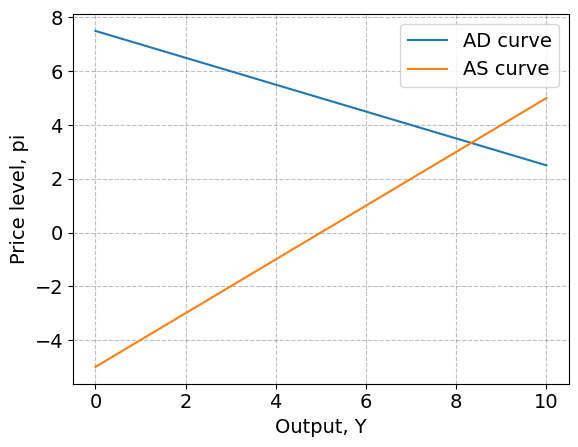

In [306]:

#Defing some parameters
alpha_1 = 1
alpha_2 = 1
h = 1
b = 1
gamma = 1

s = 0

#Defing functions for AD and AS curves
def AD(Y, pi, pi_star, g, Y_bar):
    z = (alpha_1 / (1 + alpha_2 * b)) * (g - Y_bar)
    alpha = (alpha_2 * h) / (1 + alpha_2 * b)
    return Y_bar + z - alpha * (pi - pi_star)

def AS(Y, pi, pi_1, s, Y_bar):
    return pi_1 + gamma * (Y - Y_bar) + s

#Plotting the AD and AS curves
Y_vals = np.linspace(0, 10, 100)
pi_vals = np.linspace(-5, 5, 100)

AD_curve = AD(Y_vals, pi_vals, 0, 5, 5)
AS_curve = AS(Y_vals, pi_vals, 0, s, 5)

plt.plot(Y_vals, AD_curve, label='AD curve')
plt.plot(Y_vals, AS_curve, label='AS curve')
plt.xlabel('Output, Y')
plt.ylabel('Price level, pi')
plt.legend()
plt.show()

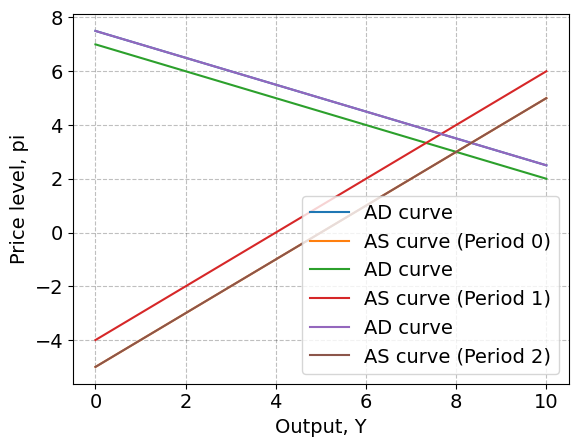

In [307]:
#Defing parameters again
alpha_1 = 1
alpha_2 = 1
h = 1
b = 1
gamma = 1

#Initial supply shock
s_0 = 0  

#Temporary negative supply shock in period 1
s_1 = 1  

#Returning to initial equilibrium in period 2
s_2 = 0  

#Defing functions for AD and AS curves again
def AD(Y, pi, pi_star, g, Y_bar):
    z = (alpha_1 / (1 + alpha_2 * b)) * (g - Y_bar)
    alpha = (alpha_2 * h) / (1 + alpha_2 * b)
    return Y_bar + z - alpha * (pi - pi_star)

def AS(Y, pi, pi_1, s, Y_bar):
    return pi_1 + gamma * (Y - Y_bar) + s

#Defining periods
periods = ['Period 0', 'Period 1', 'Period 2']

# Define shocks for each period
s = [s_0, s_1, s_2]

#Defining initial values for Y and pi
Y_0 = 5
pi_0 = 0

#Defining containers for Y and pi values for each of the three periods
Y_vals = np.zeros((len(periods), 100))
pi_vals = np.zeros((len(periods), 100))

#Calculating Y and pi for each period
for i in range(len(periods)):
    Y_vals[i] = np.linspace(0, 10, 100)
    pi_vals[i] = AS(Y_vals[i], pi_0, pi_0, s[i], Y_0)

#Plot the AD and AS curves for each period using a for loop
for i in range(len(periods)):
    AD_curve = AD(Y_vals[i], pi_vals[i], 0, 5, 5)
    AS_curve = AS(Y_vals[i], pi_vals[i], 0, s[i], 5)
    plt.plot(Y_vals[i], AD_curve, label='AD curve')
    plt.plot(Y_vals[i], AS_curve, label='AS curve ({})'.format(periods[i]))
plt.xlabel('Output, Y')
plt.ylabel('Price level, pi')
plt.legend()
plt.show()


In [308]:
pip install --upgrade plotly


Note: you may need to restart the kernel to use updated packages.


In [309]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

# Define the AD-AS model equations and parameters
def AD_equation(y, pi, pi_star, alpha, z):
    return y - y_bar - alpha * (pi - pi_star) - z

def AS_equation(y, pi, pi_minus_1, gamma, s):
    return pi - pi_minus_1 - gamma * (y - y_bar) - s

y_bar = 100
alpha_1 = 1
alpha_2 = 1
h = 1
b = 1
pi_star = 1
gamma = 1

# Define the plot function
def plot_AD_AS(s1=0, s2=0):
    # Define the shock function
    def s(t):
        if t == 0:
            return 0
        elif t == 1:
            return s1
        elif t == 2:
            return s2
        else:
            return 0
    
    # Define the steady-state equations
    z_ss = alpha_1 / (1 + alpha_2 * b) * (h / (1 + alpha_2 * b)) * (pi_star - s(0))
    alpha_ss = alpha_2 * h / (1 + alpha_2 * b)
    pi_ss = pi_star - z_ss / alpha_ss
    y_ss = y_bar + z_ss
    
    # Define the ranges for y and pi
    y_range = np.linspace(y_bar - 50, y_bar + 50, 100)
    pi_range = np.linspace(pi_ss - 2, pi_ss + 2, 100)
    
    # Create a meshgrid of y and pi values
    Y, PI = np.meshgrid(y_range, pi_range)
    
    # Evaluate the AD and AS curves at the meshgrid points
    AD = AD_equation(Y, PI, pi_star, alpha_ss, z_ss)
    AS = AS_equation(Y, PI, pi_ss, gamma, s(0))
    
    # Create a figure and plot the AD and AS curves
    fig, ax = plt.subplots(figsize=(8,6))
    ax.contour(Y, PI, AD, levels=[0], colors='red')
    ax.contour(Y, PI, AS, levels=[0], colors='blue')
    ax.axhline(y=pi_ss, color='black', linestyle='--')
    ax.axvline(x=y_ss, color='black', linestyle='--')
    ax.set_xlabel('Output (Y)')
    ax.set_ylabel('Price Level (π)')
    ax.set_title('AD-AS Model with Supply Shock')
    
    # Update the plot with the shock values for periods 1 and 2
    if s1 != 0:
        AD1 = AD_equation(Y, PI, pi_star, alpha_ss, alpha_1 / (1 + alpha_2 * b) * (h / (1 + alpha_2 * b)) * (pi_star - s1))
        AS1 = AS_equation(Y, PI, pi_ss, gamma, s1)
        ax.contour(Y, PI, AD1, levels=[0], colors='orange', linestyles='--')
        ax.contour(Y, PI, AS1, levels=[0], colors='purple', linestyles='--')
    if s2 != 0:
        AD2 = AD_equ


In [310]:

from ipywidgets import interact, fixed

# Define the AD and AS curves
def AD(y, pi, alpha, z):
    return y - ybar - alpha * (pi - pi_star) - z

def AS(y, pi, gamma, s):
    return pi - pi_1 + gamma * (y - ybar) + s

# Define the function that simulates the model with a shock
def simulate(s_type, s_periods):
    # Set the shock value and duration based on user input
    if s_type == "Positive":
        s = np.ones(T) * s_value
    else:
        s = -np.ones(T) * s_value
    s[:s_periods] = s[:s_periods] * -1
    
    # Simulate the model
    y = np.zeros(T)
    pi = np.zeros(T)
    gbar = 100
    z = alpha_1 / (1 + alpha_2 * b) * (g - gbar)
    alpha = alpha_2 * h / (1 + alpha_2 * b)
    
    # Set the initial value of y
    y[0] = ybar
    
    for t in range(1, T):
        pi[t] = pi_1 + gamma * (y[t-1] - ybar) + s[t]
        solution = sm.solve(AD(y[t-1], pi[t], alpha, z), y[t-1])
        if solution:
            y[t] = solution[0]

        
    # Plot the results
    plt.plot(y, pi)
    plt.xlabel("Output")
    plt.ylabel("Inflation")
    plt.title("AD-AS Model with Shock")
    plt.show()


# Define the default parameter values
ybar = 100
pi_star = 2
pi_1 = 2
gamma = 0.5
s_value = 1
alpha_1 = 1
alpha_2 = 1
b = 1
h = 1
g = 1
T = 10

# Create the interactive plot
interact(simulate, s_type=["Positive", "Negative"], s_periods=(0, T-1), 
         ybar=fixed(ybar), pi_star=fixed(pi_star), pi_1=fixed(pi_1), 
         gamma=fixed(gamma), s_value=(0.1, 10), alpha_1=fixed(alpha_1), 
         alpha_2=fixed(alpha_2), b=fixed(b), h=fixed(h), g=fixed(g), T=fixed(T));


interactive(children=(Dropdown(description='s_type', options=('Positive', 'Negative'), value='Positive'), IntS…

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 